Innledning:

Denne rapporten blir todelt i to forskjellige oppgaver som hører sammen. Den første delen går på hvordan et system med monomerer oppfører seg i en løsning, mens del to fokuserer på polymerer. Polymerer er monomerer med samme ladning som er koplet sammen med kovalente bindinger. Disse polymererene grupperes sammen, så i utgangspunktet så ser oppgaven på hvordan den kovalente bindingen mellom monomerer påvirker systemet og formasjoner/grupperinger. Oppgaven 1 tar for seg i stor grad hvordan systemet med monomerer påvirkes når de "clustrer/grupperes" under forskjellige temperaturer. Dette betyr at det er en samling av monomerer med forskjellige ladninger (-1 og 1) som ligger inntil hverandre. Her observeres det kvalitative forskjeller av gruppedannelser av monomerer ved forskjellige temperaturer når de clustres under monte carlo simulasjonen. Dette innebærer hvordan temperaturen påvirker gjennomsnittsstørrelsene til disse clustrene som følge av hvor mye temperaturen i systemet er. Ved større clustrer av slike monomer, så vil energien til systemet bli redusert. I tillegg, så blir energien i systemet med monomer som ikke har blitt grupperet beregnet i oppgaven. Her observeres det også på når energien i systemet når et likevektspunkt ved simulasjoner på 200K og 500K, og hvor mange steg det krever. Oppgave 2 (det gruppen har gjort) tok for seg i stor grad det samme som oppgave 1, bare med polymerer istedenfor clustere. 

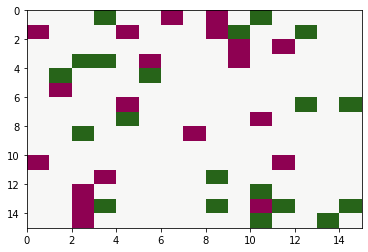

In [1]:
#Oppgave 1 a) og b)
from numba import jit
import numpy as np
import matplotlib.pyplot as plt


def generate_grid_of_monomers(N,M):
    grid = np.zeros((N, N), dtype=np.dtype('i2')) #lager et grid av riktig størrelse fylt av nuller
    for i in range(M):
        randomPosition = (np.random.randint(N),np.random.randint(N)) #velger tilfeldig koordinat
        while grid[randomPosition] != 0:  #hvis koordinatet ikke er opptatt setter vi en positiv monomer der, til vi har M stk
            randomPosition = (np.random.randint(N),np.random.randint(N))
        grid[randomPosition] = i+1
    for i in range(M):
        randomPosition = (np.random.randint(N),np.random.randint(N)) #så det samme for negative monomerer
        while grid[randomPosition] != 0:
            randomPosition = (np.random.randint(N),np.random.randint(N))
        grid[randomPosition] = -(i+1)
    return grid
    

def visualize_grid(grid, cmap='PiYG', low_val = -1, high_val = 1): #viser by default kun farger for verdier mellom -1 og 1
    plt.pcolormesh(grid,cmap=cmap, vmin = low_val, vmax = high_val)
    plt.gca().invert_yaxis() #plotter i matrisekoordinater

N, M = 15, 20
Example_system = generate_grid_of_monomers(N,M)
visualize_grid(Example_system)

In [2]:
@jit(nopython=True)
def get_neighbors_coordinates(N, i, j):
    neighborarray = [[i, (j-1)%N],
                     [i, (j+1)%N],
                     [(i-1)%N, j],
                     [(i+1)%N, j]]
    return neighborarray

@jit(nopython=True)
def get_neighboring_monomers(grid, N, i, j):
    neighborarray = get_neighbors_coordinates(N, i, j)
    deletion_list=[]
    for neighbor in neighborarray:
        if grid[neighbor[0],neighbor[1]]==0:
            deletion_list.append(neighbor)
    for monomer in deletion_list:
        neighborarray.remove(monomer)
    return neighborarray

print(get_neighboring_monomers(Example_system, N, 0, 0))
print(get_neighbors_coordinates(N, 0, 0))

[[1, 0]]
[[0, 14], [0, 1], [14, 0], [1, 0]]


In [3]:
alpha_1 = ((1.6022E-19)**2)/(4*np.pi*(8.8542E-12)*78*(23.0E-6)**2)
@jit(nopython=True)
def energy_calculation(grid, N, alpha = alpha_1): #grid er gridet som blir generert gjennom monomer_grid
    energy = 0
    monomers = []
    for i in range(len(grid[0])):
        for j in range(len(grid[i])):
            if grid[i][j] != 0:
                monomers.append([i, j])
    for monomer in monomers:
        i,j = monomer[0], monomer[1]
        for neighbor in get_neighboring_monomers(grid, N, i, j):
            sign = grid[neighbor[0], neighbor[1]]*grid[i, j]
            if sign < 0:
                sign = -1
            elif sign > 0:
                sign = 1
            energy += sign #summerer opp monomer energy
            #returnerer E/alpha dvs antall interaksjoner mellom monomerer (negativ for forskjellig fortegn)
    return energy*alpha/2 #deler på 2 fordi vi itererer over alle monomerer og det er 2 monomerer i enhver interaksjon

In [4]:
# We use the convention for directions: 0 = left, 1= right, 2=up, 3=down
# If we try to move monomers on top of a different monomer, nothing happens (This is an illegal move)
@jit(nopython=True)
def move_monomer_fast(grid, monomer_value, direction, N):
    for i in range(len(grid[0])):
        for j in range(len(grid[i])):
            if grid[i][j] == monomer_value:
                monomer_coordinates = [i, j]
            else:
                pass
    
    array_of_all_neighbor_coordinates = get_neighbors_coordinates(N=N, i=monomer_coordinates[0],
                                                                 j=monomer_coordinates[1])
    desired_neigbor_coordinate = array_of_all_neighbor_coordinates[direction]

    if grid[desired_neigbor_coordinate[0], desired_neigbor_coordinate[1]]==0:
        grid[desired_neigbor_coordinate[0], desired_neigbor_coordinate[1]] = monomer_value
        grid[monomer_coordinates[0], monomer_coordinates[1]] = 0
    return grid

In [5]:
alpha_1 = ((1.6022E-19)**2)/(4*np.pi*(8.8542E-12)*78*(23.0E-6)**2)
@jit(nopython=True)
def monte_carlo_energy(N_s, N, M, T, grid,alpha = alpha_1):
    beta = 1/(T*1.380649E-23) #1/(kB*T)
    epsilon = np.zeros(N_s, dtype=np.dtype('f8'))
    for i in range(N_s):
        E = energy_calculation(grid, N)
        #Generates a random integer between 0 and 3 (low is inclusive, high is not)
        random_direction = np.random.randint(low=0, high=4) 
        # For generating a random monomer value, we generate the magntitude and sign seperately.
        magnitude = np.random.randint(1, M + 1)
        sign = 2 * np.random.randint(0, 2) - 1 # Easy way to generate random sign
        new_grid= grid.copy()
        new_grid = move_monomer_fast(new_grid, sign*magnitude, random_direction, N) # This function already avoids illegal moves
        E_new = energy_calculation(new_grid, N)
        if E_new < E:
            grid = new_grid
            E = E_new
        elif np.random.random()<np.exp(-beta*(E_new-E)):
            grid = new_grid
            E = E_new
        else:
            pass
        epsilon[i] = float(E/alpha)
    return epsilon, grid

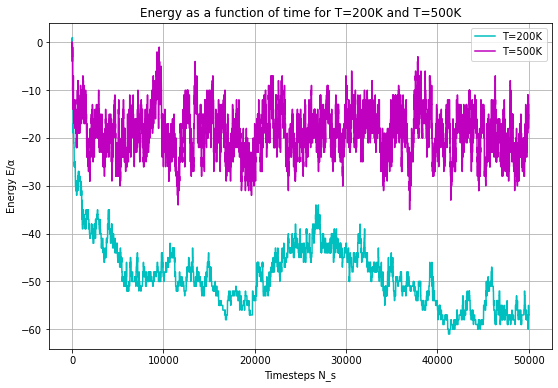

Koden tar 30.67026138305664 sekunder å kjøre


'We find that timesteps needed to reach equilibrium is at approximately 5000 steps for T=500K and at approx 20000 steps\nfor T=200K.'

In [33]:
import time

t0 = time.time()

N,M = 15, 25
N_s=50000
grid=generate_grid_of_monomers(N,M)
T_1=200
T_2=500
timesteps = np.arange(N_s)
low_T_energy, low_T_grid = monte_carlo_energy(N_s, N, M, T_1, grid)
np.savez('lowTsimulation.npz', low_T_grid=low_T_grid)

high_T_energy, high_T_grid = monte_carlo_energy(N_s, N, M, T_2, grid)

plt.figure(figsize=(9,6))
plt.title('Energy as a function of time for T=200K and T=500K')
plt.plot(timesteps, low_T_energy, 'c')
plt.plot(timesteps, high_T_energy, 'm')
plt.legend(['T=200K','T=500K'])
plt.grid(True)
plt.xlabel('Timesteps N_s')
plt.ylabel('Energy E/α')
plt.show()


t1 = time.time()

print(f"Koden tar {t1-t0} sekunder å kjøre")

t_equil is smaller for higher teperatures as the likelihood of monomers moving away from local minima is larger,
i.e. monomers move more frequently and also settle in a equilibrium faster, but this equilibrium has a higher potential energy
than the low temperature variant because the temperature (by definition) increases the energy of the system. In the high T 
simulation the monomers move more easily away from "bonds" with other monomers, this is the reason for the higher potential 
energy. For the lower temperature simulation this takes more moves to accomplish, as the probability of the low 
temperature grid being in a local equilibrium is larger than for the high temperature grid.'''

Teorispørsmål: We find that timesteps needed to reach equilibrium is at approximately 5000 steps for T=500K and at approx 20000 steps for T=200K.

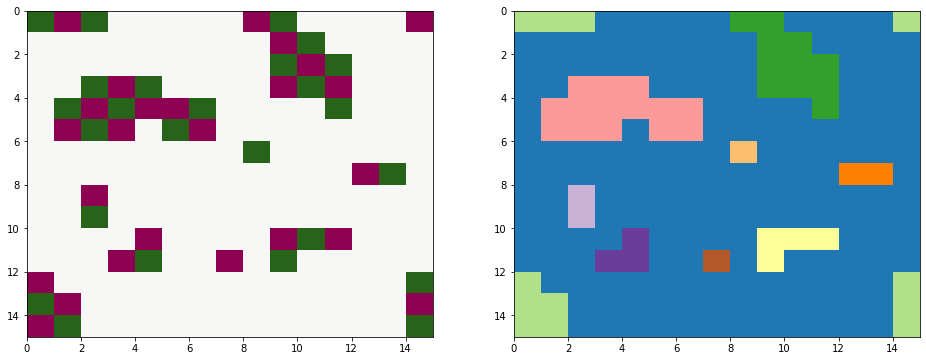

In [7]:
#Oppgave 1 g)
@jit(nopython=True)
def generate_cluster_grid(grid, M):
    largest_possible_cluster_value = 2*M
    cluster_number = largest_possible_cluster_value + 1
    cluster_grid = np.copy(grid) #unngår å endre på grid andre steder i koden
    #nummererer cluster og gir hvert cluster et nummer som garantert er høyere enn hvis alle monomerer er adskilt
    for monomer in np.argwhere(cluster_grid!=0): #finner koordinater til punkter i grid som ikke er lik 0
        i,j = monomer[0],monomer[1]
        cluster_grid[i][j] = cluster_number #lager nytt cluster
        cluster_number += 1
        nearest_neighbors = get_neighboring_monomers(grid, N, i, j)
        for neighbor in nearest_neighbors:
            if(abs(cluster_grid[neighbor[0]][neighbor[1]])<abs(cluster_grid[i][j])):
                if (cluster_grid[neighbor[0]][neighbor[1]]>=largest_possible_cluster_value):
                #hvis naboen er del av et cluster allerede får monomeren naboens verdi
                    for cluster_item in np.argwhere(cluster_grid == cluster_grid[i][j]):
                    #for alle monomerer i andre cluster som monomeren er en del av
                        cluster_grid[cluster_item[0],cluster_item[1]] = cluster_grid[neighbor[0]][neighbor[1]]
                    cluster_number -= 1
            else:
                for cluster_item in np.argwhere(cluster_grid == cluster_grid[neighbor[0]][neighbor[1]]):
                    #for alle monomerer i andre cluster som naboen er en del av
                        cluster_grid[cluster_item[0],cluster_item[1]] = cluster_grid[i][j]
                    
                '''merger cluster ved å gi alle monomerer i clusteret med høyest verdi verdien til det clusteret
                som er "eldst", dvs. lavest cluster verdi over 2, hvis ikke naboen er del av et eksisterende cluster,
                legger vi til naboen i monomerens cluster'''
    for monomer in np.argwhere(cluster_grid!=0): #finner koordinater til punkter i grid som ikke er lik 0
        i,j = monomer[0],monomer[1]
        cluster_grid[i][j] -= largest_possible_cluster_value #gir clusterne lavest mulig verdi
    return cluster_grid


lowTgrid = np.load('lowTsimulation.npz')['low_T_grid']
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
visualize_grid(lowTgrid)
plt.subplot(1,2,2)
visualize_grid(generate_cluster_grid(lowTgrid, M), cmap = 'Paired', high_val = None)
plt.show()

In [8]:
@jit(nopython=True)
def mean_cluster_size(cluster_grid, M):
    amount_of_clusters = 1
    for row in cluster_grid:
        for i in row:
            if i > amount_of_clusters: #clusters are numbered so largest number in grid = amount of clusters
                amount_of_clusters = i
    return 2*M/amount_of_clusters

In [9]:
@jit(nopython=True)
def monte_carlo_cluster(t_equil, t_r, n, N, M, T, grid):
    beta = 1/(T*1.380649E-23) #1/(kB*T)
    t_equil = int(t_equil)
    N_s = t_equil + t_r*n #Total time steps are steps until equilibrium plus steps between measurements times n measurements
    cluster_sizes = []
    
    for i in range(int(N_s)):
        if(i>=t_equil):
            if((i - t_equil)%(t_r)==0):
                current_mean_cluster_size = mean_cluster_size(generate_cluster_grid(grid, M), M)
                cluster_sizes.append(current_mean_cluster_size)
            else:
                pass
        else:
            pass
        E = energy_calculation(grid, N)
        #Generates a random integer between 0 and 3 (low is inclusive, high is not)
        random_direction = np.random.randint(low=0, high=4) 
        # For generating a random monomer value, we generate the magntitude and sign seperately.
        magnitude = np.random.randint(1, M + 1)
        sign = 2 * np.random.randint(0, 2) - 1 # Easy way to generate random sign
        new_grid = np.copy(grid)
        new_grid = move_monomer_fast(new_grid, sign*magnitude, random_direction, N) # This function already avoids illegal moves
        E_new = energy_calculation(new_grid, N)
        if E_new < E:
            grid = new_grid
            E = E_new
        elif np.random.random()<np.exp(-beta*(E_new-E)):
            grid = new_grid
            E = E_new
        else:
            pass
    return sum(cluster_sizes)/n #the estimator (avg.) for the cluster size at given T
    

In [10]:
t_max = 10000
s = 1/200
C = 15000
T_l = 100
T_h = 1000
t_r = 1000
n = 100

temperatures = np.linspace(T_l, T_h,10)
equilibriums = []
for T in temperatures:
    equilibriums.append(t_max*np.exp(-s*(T-T_l)) + C)

In [11]:
N, M = 15, 25
t0 = time.time()

mean_cluster_size_list = np.zeros(10)
grid=generate_grid_of_monomers(N,M)
for i in range(10):
    T, t_equil = temperatures[i], equilibriums[i]
    mean_cluster_size_list[i] = monte_carlo_cluster(t_equil, t_r, n, N, M, T, grid)

t1 = time.time()

print(f"Koden tar {t1-t0} sekunder å kjøre")

Koden tar 353.7515618801117 sekunder å kjøre


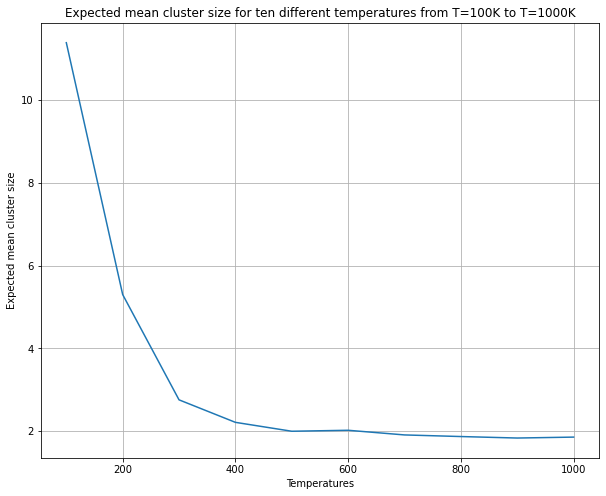

In [12]:
plt.figure(figsize=(10,8))
plt.title('Expected mean cluster size for ten different temperatures from T=100K to T=1000K')
plt.plot(temperatures, mean_cluster_size_list)
plt.grid(True)
plt.xlabel('Temperatures')
plt.ylabel('Expected mean cluster size')
plt.show()

In [13]:
N, M = 15, 25
    
mean_cluster_size_list = np.zeros(10)
grid=generate_grid_of_monomers(N,M)
for i in range(10):
    T, t_equil = temperatures[i], equilibriums[i]
    mean_cluster_size_list[i] = monte_carlo_cluster(t_equil, t_r, n, N, M, T, grid)

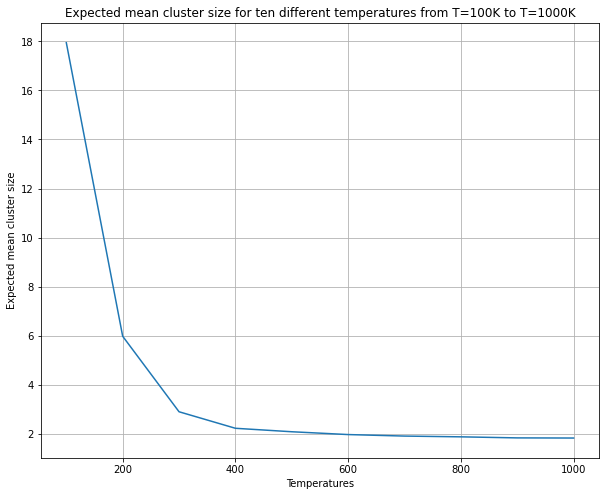

In [14]:
plt.figure(figsize=(10,8))
plt.title('Expected mean cluster size for ten different temperatures from T=100K to T=1000K')
plt.plot(temperatures, mean_cluster_size_list)
plt.grid(True)
plt.xlabel('Temperatures')
plt.ylabel('Expected mean cluster size')
plt.show()

In [25]:
print(np.exp(-3*alpha_1/(100*1.380649E-23)))
print(np.exp(-alpha_1/(100*1.380649E-23)))
print(np.exp(-3*alpha_1/(200*1.380649E-23)))
print(np.exp(-alpha_1/(200*1.380649E-23)))
print(np.exp(-3*alpha_1/(1000*1.380649E-23)))
print(np.exp(-alpha_1/(1000*1.380649E-23)))

5.29049124052194e-06
0.017424700947186386
0.002300106788938709
0.13200265507627634
0.29672189912401165
0.6669857160743088


-d- is larger at smaller T as the probalilty of a monomer moving away from even the weakest bond at T=100K is
less than 2%, while for the highest temperature T=1000K the probability of escaping the strongest possible bond
is about 30%, this means that the likelihood of larger clusters forming is quite small as the bonds get very weak at high 
temperatures (measured by the probability of monomers escaping bonds). Initially we thought that high energy simulations would 
be more efficient as they are less likely trapped in local minima, therefore we were initially surprised by the results. 
Using an n=100 should give us a valid result as the standard error decreases proportional to 1/sqrt(n). Both simulations give 
us a similar decrease in cluster size as temperature increases, which looks to be roughly hyperbolic. As mentioned lower 
temperatures have a larger probability of being trapped at local minima so the variation in lower temperatures should depend 
on chance at a much higher degree than higher temperature simulations. This is the reason for the larger variation at low 
temperatures, the initial conditions decide much of the final configuration, but for higher temperatures the configuration at 
equilibrium will be very similar independent of initial conditions.

These are equivalent to probabilities of monomers escaping bonds with 3 or 1 neighbors of opposite sign, for T=100K, T=200K, 
and T=1000K respectively.


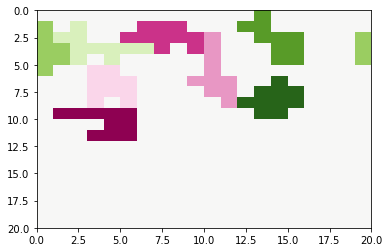

In [16]:
#Oppgave 2 a)
def generate_grid_of_polymers(N,M,L):
    grid = generate_grid_of_monomers(N,M)
    for a in range(1, M+1):
        
        a_pos_valued_monomers = np.argwhere(grid==a)
        index_pos=1
        while index_pos<L:
            np.random.shuffle(a_pos_valued_monomers)
            initial_coordinates = a_pos_valued_monomers[0]
            neighboring_fields = get_neighbors_coordinates(N, initial_coordinates[0], initial_coordinates[1])
            np.random.shuffle(neighboring_fields)
            selected_neighbor = neighboring_fields[0]
            if grid[selected_neighbor[0]][selected_neighbor[1]] == 0:
                grid[selected_neighbor[0]][selected_neighbor[1]] = a
            else:
                pass
            a_pos_valued_monomers = np.argwhere(grid==a)
            index_pos=len(a_pos_valued_monomers)

            
        a_neg_valued_monomers = np.argwhere(grid==-a)
        index2=1
        while index2<L:
            np.random.shuffle(a_neg_valued_monomers)
            initial_coordinates = a_neg_valued_monomers[0]
            neighboring_fields = get_neighbors_coordinates(N, initial_coordinates[0], initial_coordinates[1])
            np.random.shuffle(neighboring_fields)
            selected_neighbor = neighboring_fields[0]
            if grid[selected_neighbor[0]][selected_neighbor[1]] == 0:
                grid[selected_neighbor[0]][selected_neighbor[1]] = -a
            else:
                pass
            a_neg_valued_monomers = np.argwhere(grid==-a)
            index2=len(a_neg_valued_monomers)
    return grid
            
            
polymers = generate_grid_of_polymers(20, 4, 10)
visualize_grid(polymers, low_val = None, high_val = None)
plt.show()


In [29]:
#Oppgave 2b)
alpha_2= ((1.6022E-19)**2)/(4*np.pi*(8.8542E-12)*78*(91.0E-6)**2)
@jit(nopython=True)
def polymer_energy_calculation(grid, N):
    energy = 0
    monomers = np.argwhere(grid!=0)
    
    for monomer in monomers:
        i,j = monomer[0], monomer[1]
        for neighbor in get_neighboring_monomers(grid, N, i, j):
            sign = grid[neighbor[0], neighbor[1]]*grid[i, j]
            if sign < 0:
                sign = -1
            elif sign > 0:
                sign = 1
            if grid[neighbor[0], neighbor[1]] == grid[i, j]:
                sign = 0
            energy += sign #summerer opp monomer energy
            #returnerer E/alpha dvs antall interaksjoner mellom monomerer (negativ for forskjellig fortegn)
    return energy*alpha_2/2 #deler på 2 fordi vi itererer over alle monomerer og det er 2 monomerer i enhver interaksjon

In [18]:
#Oppgave 2c)
@jit(nopython=True)
def rigid_move_polymer(grid, polymer_value, direction, N, L):
    polymer_coordinates = np.argwhere(grid == polymer_value)
    new_polymer_coordinates = []
    new_grid = grid.copy()
    for monomer_coordinate in polymer_coordinates:
        
        array_of_all_neighbor_coordinates = get_neighbors_coordinates(N=N, i=monomer_coordinate[0], j=monomer_coordinate[1])
        desired_neigbor_coordinate = array_of_all_neighbor_coordinates[direction]
        #changing coordinates of each monomer in the polymer
    
        if grid[desired_neigbor_coordinate[0], desired_neigbor_coordinate[1]]==polymer_value:
            new_polymer_coordinates.append(desired_neigbor_coordinate)
        elif grid[desired_neigbor_coordinate[0], desired_neigbor_coordinate[1]]==0:
            new_polymer_coordinates.append(desired_neigbor_coordinate)
        else:
            return grid
    for monomer_coordinate in polymer_coordinates:
        new_grid[monomer_coordinate[0], monomer_coordinate[1]] = 0 #deleting old positions
    for monomer_coordinate in new_polymer_coordinates:
        new_grid[monomer_coordinate[0], monomer_coordinate[1]] = polymer_value
        
    return new_grid

In [31]:
#Oppgave 2D)
alpha_2= ((1.6022E-19)**2)/(4*np.pi*(8.8542E-12)*78*(91.0E-6)**2)
@jit(nopython=True)
def monte_carlo_polymer(N_s, N, M, L, T, grid, moving_function=rigid_move_polymer):
    beta = 1/(T*1.380649E-23) #1/(kB*T)
    for i in range(N_s):
        E = polymer_energy_calculation(grid, N)
        #Generates a random integer between 0 and 3 (low is inclusive, high is not)
        random_direction = np.random.randint(low=0, high=4) 
        # For generating a random polymer value, we generate the magntitude and sign seperately.
        magnitude = np.random.randint(1, M + 1)
        sign = 2 * np.random.randint(0, 2) - 1 # Easy way to generate random sign
        new_grid = grid.copy()
        new_grid = moving_function(new_grid, sign*magnitude, random_direction, N, L) # This function already avoids illegal moves
        E_new = polymer_energy_calculation(new_grid, N)
        if E_new < E:
            grid = new_grid
            E = E_new
        elif np.random.random()<np.exp(-beta*(E_new-E)):
            grid = new_grid
            E = E_new
        else:
            pass

    return grid

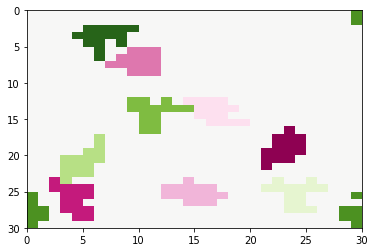

Koden tar 22.26749038696289 sekunder å kjøre


In [34]:
N = 30
M = 5
L = 15
N_s = 30000
T= 200
t0 = time.time()    

polymers = generate_grid_of_polymers(N, M, L)
rigid_move_grid = monte_carlo_polymer(N_s, N, M, L, T, polymers, moving_function=rigid_move_polymer)
visualize_grid(rigid_move_grid, low_val = None, high_val = None)
plt.show()


t1 = time.time()

print(f"Koden tar {t1-t0} sekunder å kjøre")

We tested the code running the simulation with same parameters as in 1f) and g), getting similar results. However, after 
changing a to 91 microm from 23 microm we get a much higher probabilty of moving polymers regardless of the energy difference. We 
have calculated the probability, like we did before but with new alpha. At T=200 the probability is 6 times as high with 
a = 91 microm. Still, the polymers seem to cluster to a degree. Comparing the code with the one used in 1f), we find that one 
simulation there took a bit less time (about 2/3 of the time) than it takes here. This is because we have to iterate over the 
monomers in the polymer and over a larger grid to search for polymers. Also, the move function, probably the largest factor, is
more complex as it moves every monomer in the polymer on a new grid, and compares the grids to see if the move was legal, which 
takes a bit of time. Refraining from plotting energy as a function of time avoids adding an item to an array 30000 times, 
which saves some run time.

In [21]:
def is_polymer_broken(grid, polymer_value, N):
    polymer_coordinates = np.argwhere(grid==polymer_value)
    for monomer in polymer_coordinates:
        i, j = monomer[0], monomer[1]
        attachment_points = get_neighboring_monomers(grid, N, i, j)
        
        deletion_list=[]
        for neighbor in attachment_points:
            if grid[neighbor[0],neighbor[1]]!=polymer_value:
                deletion_list.append(neighbor)
        for neighbor in deletion_list:
            attachment_points.remove(neighbor)
        if len(attachment_points) == 0:
            return True
        #hvis en monomer har ingen naboer av samme verdi er polymeren brutt.

    return False

In [24]:
print(np.exp(-3*alpha_2/(100*1.380649E-23)))
print(np.exp(-alpha_2/(100*1.380649E-23)))
print(np.exp(-3*alpha_2/(200*1.380649E-23)))
print(np.exp(-alpha_2/(200*1.380649E-23)))
print(np.exp(-3*alpha_2/(1000*1.380649E-23)))
print(np.exp(-alpha_2/(1000*1.380649E-23)))

0.46018316959220684
0.772046710727605
0.6783680192876186
0.878661886465781
0.9253223946850713
0.9744607650499927


Diskusjon:

From task 1f) we see that t_equil is smaller for T=500K than for T=200K, the higher the temperature the more monomers move and therefore higher likelihood of moving away from the local minima, and then settle in an equilibrium faster. 
The mean cluster size decreases as temperature increases, when T=1000K, the probability of moving away from the strongest bond is at 30% while at T=100K the probability of moving away from even the weakest bond is 2%, meaning the bonds are much stronger at lower temperatures and therefore much harder to break out from, making the clusters at higher temperatures smaller because more monomers are able to break out from them. One should think that the higher energy simulations would be more efficient as the probability of being trapped in local minima is smaller. Using n=100 gives valid result and decreasing standard error, both simulations give a similar decrease in cluster size as temperature increases. Because the lower temperature the higher probabability of being trapped at local mimima, and therefore the variation in lower temperatures have higher dependency on chance, which can make the low temperatures higher in discrepancy. At low temperatures, the final configuration at equilibrium is very dependent on the initial conditions, but at higher temperatures the equilibrium configuration is more independent on the initial conditions. The energy of the system depends on the size of the clusters. If there the mean clusters in the system is bigger, the lower the total energy of the system is. This is because there's more interactions between monomers with different charges when the clusters are bigger. 

Initially we thought that high energy simulations would be more efficient as they are less likely trapped in local minima, therefore we were initially surprised by the results. Using an n=100 should give us a valid result as the standard error decreases proportional to 1/sqrt(n). Both simulations give us a similar decrease in cluster size as temperature increases, which looks to be roughly hyperbolic. As mentioned lower temperatures have a larger probability of being trapped at local minima so the variation in lower temperatures should depend on chance at a much higher degree than higher temperature simulations. This is the reason for the larger variation at low temperatures, the initial conditions decide much of the final configuration, but for higher temperatures the configuration at equilibrium will be very similar independent of initial conditions.